<a href="https://colab.research.google.com/github/19WH1A0501/Stock-Prediction-Using-LSTM-and-ML-Methods/blob/main/3_final_major_HDFC_CNN_LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM,Conv1D,Conv2D,MaxPooling2D,MaxPooling1D,Flatten
from keras.layers import Dense, Dropout
import pandas as pd
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
#from datetime import datetime

from tensorflow.compat.v1.keras.layers import CuDNNLSTM,Bidirectional
seed=42

In [ ]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/major datasets /HDFC_Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Adj Close,Volume,P_mean,P_sum,twt_count
0,2018-01-01,936.349976,940.375000,925.250000,927.250000,899.247742,3290258,-0.076923,-1,13
1,2018-01-02,929.275024,937.500000,929.275024,936.174988,907.903259,2388158,-0.375000,-6,16
2,2018-01-03,937.500000,939.125000,925.599976,926.325012,898.350708,2265644,-0.307692,-4,13
3,2018-01-04,926.500000,932.750000,926.500000,929.950012,901.866272,1186888,-0.200000,-5,25
4,2018-01-05,931.500000,934.025024,927.775024,931.799988,903.660339,1435434,-0.303030,-10,33
...,...,...,...,...,...,...,...,...,...,...
1230,2022-12-26,1599.500000,1639.000000,1590.000000,1629.449951,1629.449951,4953661,-0.254545,-14,55
1231,2022-12-27,1633.000000,1635.949951,1613.500000,1631.099976,1631.099976,3963386,-0.189189,-7,37
1232,2022-12-28,1623.099976,1633.000000,1623.099976,1629.800049,1629.800049,4345935,-0.148936,-7,47
1233,2022-12-29,1620.099976,1643.500000,1611.000000,1641.300049,1641.300049,5506448,-0.276596,-13,47


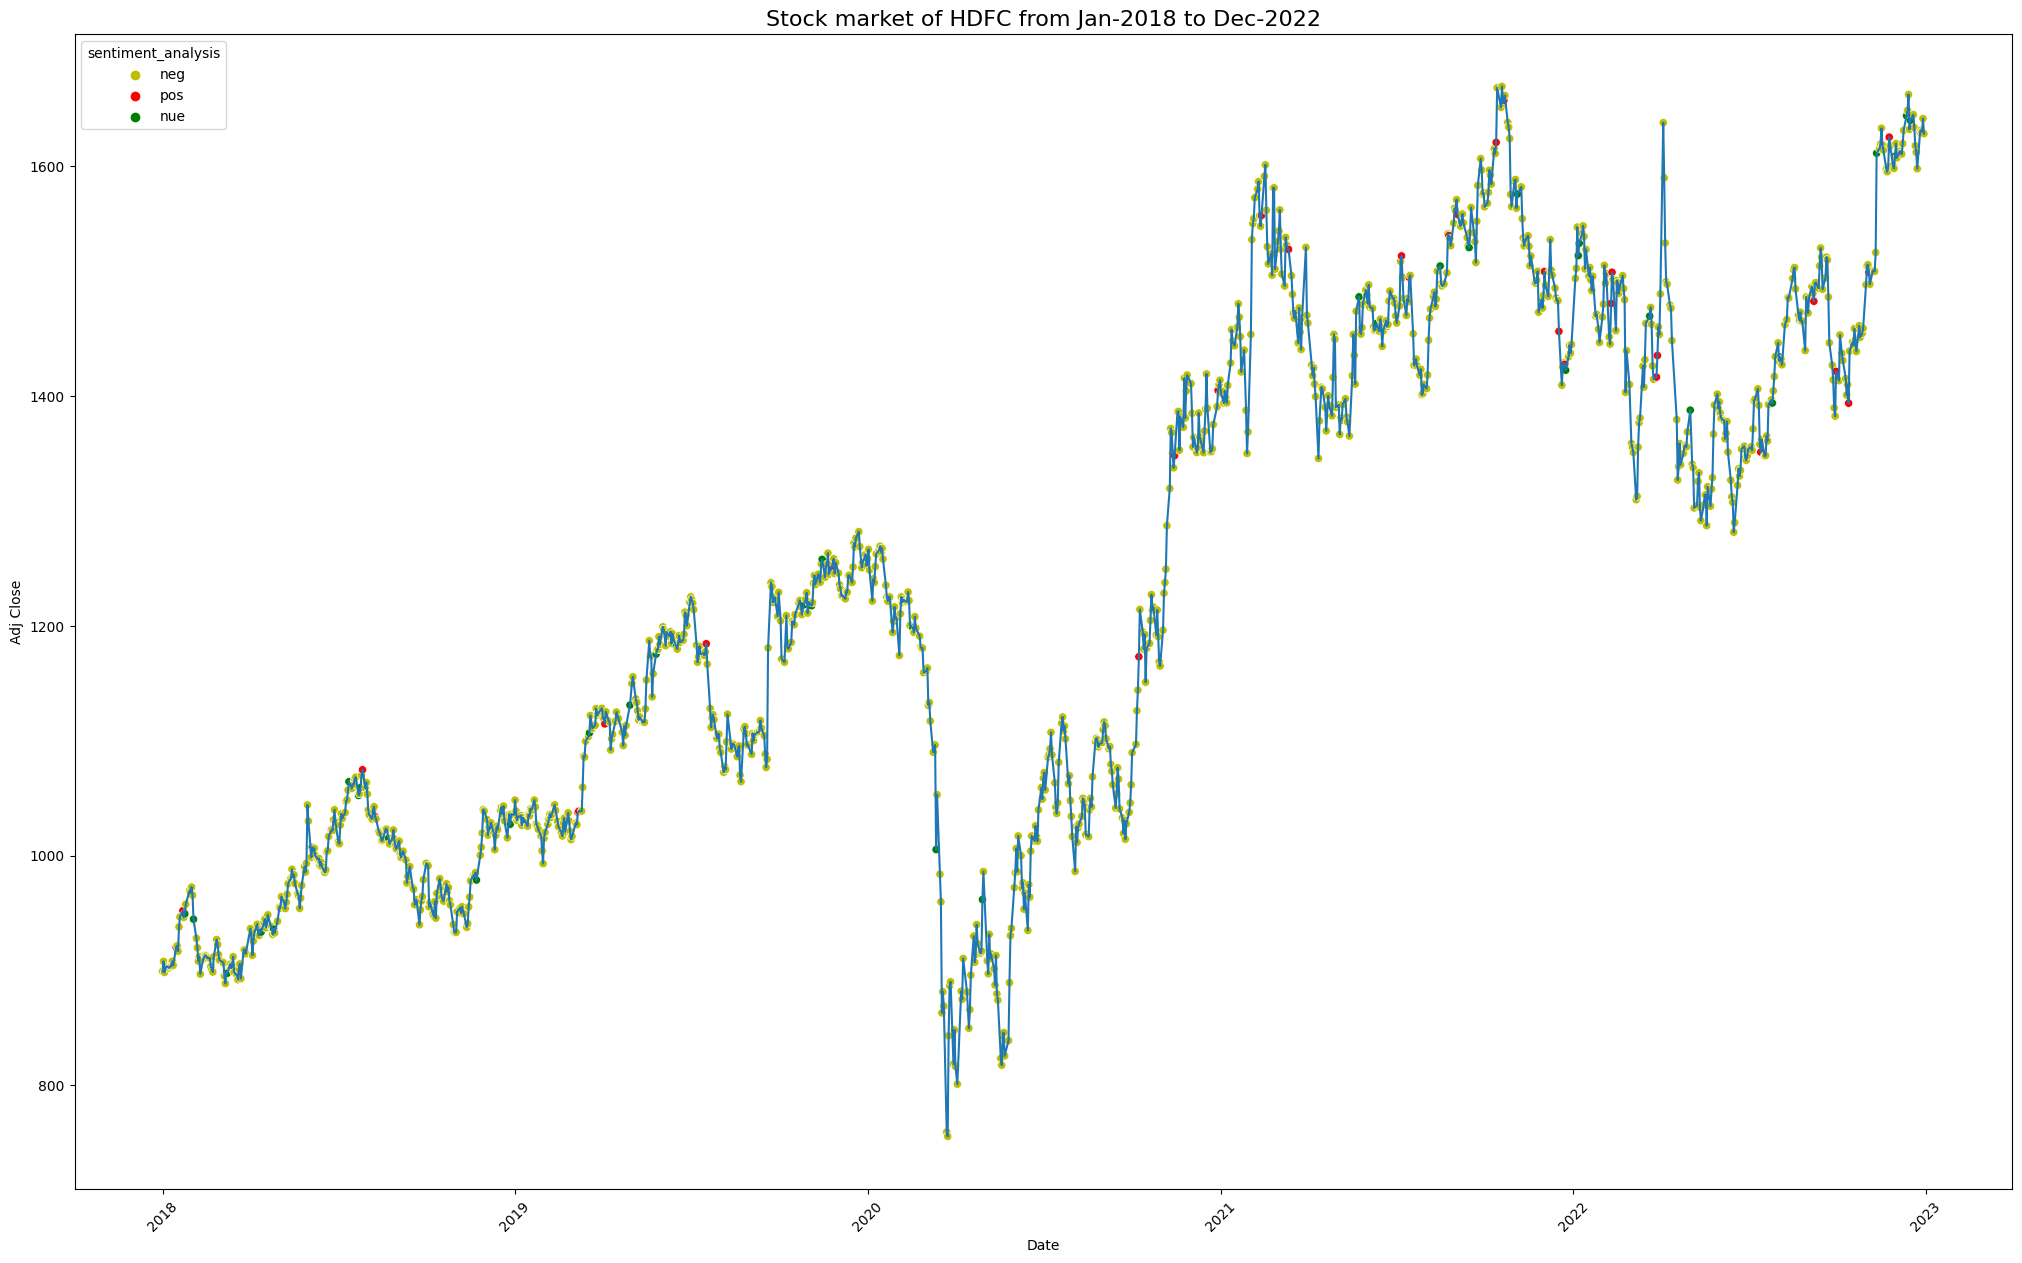

In [ ]:
import seaborn as sns
plt.figure(figsize=(25,15));
sns.lineplot(x=df["Date"],y=df["Adj Close"])
df['sentiment_analysis']=df['P_mean']
df['sentiment_analysis']=df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=df["Date"],y=df['Adj Close'],hue=df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of HDFC from Jan-2018 to Dec-2022",fontsize=16);

In [ ]:
df['sentiment_analysis'].value_counts()

neg    1163
nue      38
pos      34
Name: sentiment_analysis, dtype: int64

In [ ]:
train_dates = pd.to_datetime(df['Date'])
# print(train_dates.tail(15)) #Check last few dates.

#Variables for training
cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'P_mean',
        ]
#Date and volume columns are not used in training.
print(cols)

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)
df_for_training.index=df['Date']
df_for_training

['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean']


,Open,High,Low,Close,Volume,Adj Close,P_mean
Date,,,,,,,
2018-01-01,936.349976,940.375000,925.250000,927.250000,3290258.0,899.247742,-0.076923
2018-01-02,929.275024,937.500000,929.275024,936.174988,2388158.0,907.903259,-0.375000
2018-01-03,937.500000,939.125000,925.599976,926.325012,2265644.0,898.350708,-0.307692
2018-01-04,926.500000,932.750000,926.500000,929.950012,1186888.0,901.866272,-0.200000
2018-01-05,931.500000,934.025024,927.775024,931.799988,1435434.0,903.660339,-0.303030
...,...,...,...,...,...,...,...
2022-12-26,1599.500000,1639.000000,1590.000000,1629.449951,4953661.0,1629.449951,-0.254545
2022-12-27,1633.000000,1635.949951,1613.500000,1631.099976,3963386.0,1631.099976,-0.189189
2022-12-28,1623.099976,1633.000000,1623.099976,1629.800049,4345935.0,1629.800049,-0.148936


In [ ]:
_countscaler = MinMaxScaler()
scaler = _countscaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.17751855, 0.14248634, 0.20005363, ..., 0.05245646, 0.1572112 ,
        0.64957265],
       [0.16994812, 0.13934426, 0.20437117, ..., 0.03562152, 0.1666844 ,
        0.43981481],
       [0.17874912, 0.14112022, 0.20042904, ..., 0.03333517, 0.15622943,
        0.48717949],
       ...,
       [0.91236421, 0.89945355, 0.94861891, ..., 0.07215745, 0.95677835,
        0.59889677],
       [0.90915411, 0.91092896, 0.93563958, ..., 0.09381489, 0.96936474,
        0.50906225],
       [0.93579798, 0.91256831, 0.94529364, ..., 0.05751501, 0.95497244,
        0.53481481]])

In [ ]:
df_for_training_scaled[0]

array([0.17751855, 0.14248634, 0.20005363, 0.17323561, 0.05245646,
       0.1572112 , 0.64957265])

In [ ]:
trainX = []
trainY = []

n_future = 1  
n_past = 5  

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future,[0,-2]])

trainX, trainY = np.array(trainX), np.array(trainY)

print('TrainX shape = {}.'.format(trainX.shape))
print('TrainY shape = {}.'.format(trainY.shape))

TrainX shape = (1230, 5, 7).
TrainY shape = (1230, 1, 2).


In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_test_lstm_without_twitter, y_train_lstm_without_twitter, y_test_lstm_without_twitter = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_twitter, X_test_lstm_twitter, y_train_lstm_twitter, y_test_lstm_twitter = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((984, 5, 6), (984, 5, 7))

In [ ]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_twitter, X_val_lstm_without_twitter, y_train_lstm_without_twitter, y_val_lstm_without_twitter = train_test_split(X_train_lstm_without_twitter, y_train_lstm_without_twitter, test_size=0.1, shuffle=False)
X_train_lstm_twitter, X_val_lstm_twitter, y_train_lstm_twitter, y_val_lstm_twitter = train_test_split(X_train_lstm_twitter, y_train_lstm_twitter, test_size=0.1, shuffle=False)
X_train_lstm_without_twitter.shape,X_train_lstm_twitter.shape

((885, 5, 6), (885, 5, 7))

##CNN LSTM Model

In [ ]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model = Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=1, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))
    # cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))


    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    # cnn_lstm_model.build(input_shape=(trainX.shape[0], trainX.shape[1], trainX.shape[2]))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [ ]:
# fit the model

cnn_lstm_model_without_twitter = build_model((X_train_lstm_without_twitter.shape[1],X_train_lstm_without_twitter.shape[2]))
cnn_lstm_model_twitter = build_model((X_train_lstm_twitter.shape[1],X_train_lstm_twitter.shape[2]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 128)            1664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             16448     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 512)           657408    
 l)                                                              
                                                        

In [ ]:
history_without_twitter = cnn_lstm_model_without_twitter.fit(X_train_lstm_without_twitter, y_train_lstm_without_twitter, epochs=150, batch_size=64, validation_data=(X_val_lstm_without_twitter, y_val_lstm_without_twitter), verbose=1, )

Epoch 1/150
14/14 [==============================] - 27s 581ms/step - loss: 0.0712 - val_loss: 0.0696
Epoch 2/150
14/14 [==============================] - 2s 109ms/step - loss: 0.0074 - val_loss: 0.0171
Epoch 3/150
14/14 [==============================] - 2s 113ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 4/150
14/14 [==============================] - 2s 120ms/step - loss: 0.0017 - val_loss: 8.3725e-04
Epoch 5/150
14/14 [==============================] - 2s 114ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/150
14/14 [==============================] - 2s 121ms/step - loss: 0.0014 - val_loss: 7.8987e-04
Epoch 7/150
14/14 [==============================] - 3s 214ms/step - loss: 0.0014 - val_loss: 8.5218e-04
Epoch 8/150
14/14 [==============================] - 2s 159ms/step - loss: 0.0013 - val_loss: 7.7168e-04
Epoch 9/150
14/14 [==============================] - 1s 101ms/step - loss: 0.0014 - val_loss: 6.9429e-04
Epoch 10/150
14/14 [==============================] - 2s 113ms/step - 

In [ ]:
history_twitter = cnn_lstm_model_twitter.fit(X_train_lstm_twitter, y_train_lstm_twitter, epochs=150, batch_size=64, validation_data=(X_val_lstm_twitter, y_val_lstm_twitter), verbose=1, )


Epoch 1/150
14/14 [==============================] - 22s 578ms/step - loss: 0.0633 - val_loss: 0.0923
Epoch 2/150
14/14 [==============================] - 2s 112ms/step - loss: 0.0083 - val_loss: 0.0308
Epoch 3/150
14/14 [==============================] - 2s 153ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 4/150
14/14 [==============================] - 2s 158ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 5/150
14/14 [==============================] - 2s 125ms/step - loss: 0.0016 - val_loss: 7.9662e-04
Epoch 6/150
14/14 [==============================] - 2s 123ms/step - loss: 0.0015 - val_loss: 8.1651e-04
Epoch 7/150
14/14 [==============================] - 2s 122ms/step - loss: 0.0014 - val_loss: 8.4484e-04
Epoch 8/150
14/14 [==============================] - 2s 112ms/step - loss: 0.0013 - val_loss: 8.7108e-04
Epoch 9/150
14/14 [==============================] - 2s 136ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 10/150
14/14 [==============================] - 1s 104ms/step - loss

In [ ]:
cnn_lstm_model_without_twitter.evaluate(X_test_lstm_without_twitter, y_test_lstm_without_twitter)

8/8 [==============================] - 0s 11ms/step - loss: 0.0010


0.0010461458005011082

In [ ]:
cnn_lstm_model_twitter.evaluate(X_test_lstm_twitter, y_test_lstm_twitter)

8/8 [==============================] - 0s 10ms/step - loss: 8.5981e-04


0.00085981166921556

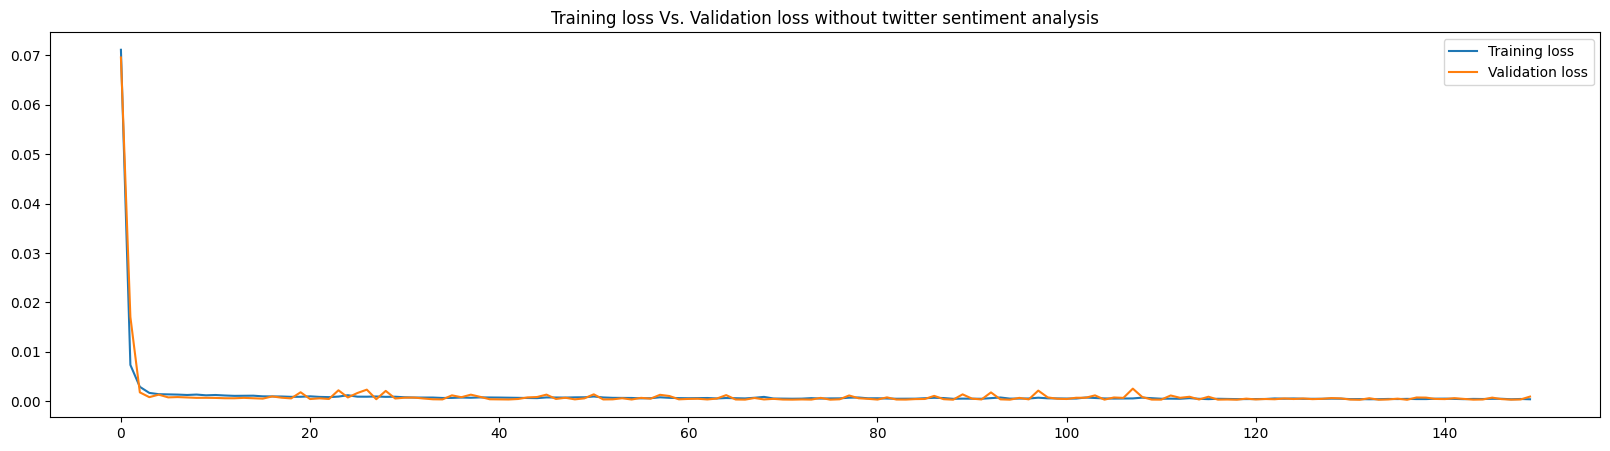

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_without_twitter.history['loss'], label='Training loss')
plt.plot(history_without_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without twitter sentiment analysis')
plt.legend()

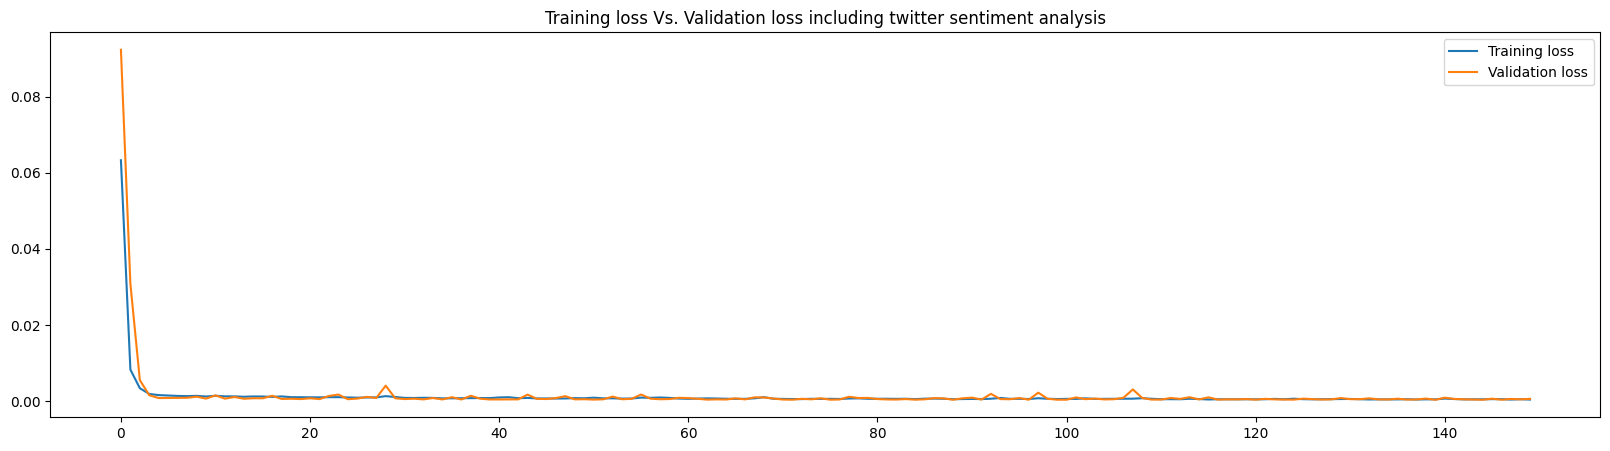

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(history_twitter.history['loss'], label='Training loss')
plt.plot(history_twitter.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including twitter sentiment analysis')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
from sklearn.metrics import accuracy_score
a = 0
c = 0
def plot_predictions_with_dates (type,twitter,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(10,6))
        if twitter :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()

        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        # acc=accuracy_score(y_actual_lstm[:,i], y_pred_lstm[:, i])
        # a += acc
        # c += 1
        print(f'Mean square error for {predicted_feature} ={error}')
    mse = mean_squared_error(y_actual_lstm, y_pred_lstm)
    print('Total mean square error', mse)
    print("RMSE :", sqrt(mse))
    # print('Accuracy', ((acc)/c)*100)

In [ ]:
training_dates= df_for_training.index[:X_train_lstm_without_twitter.shape[0]]
training_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_train_lstm_without_twitter)
training_prediction_twitter = cnn_lstm_model_twitter.predict(X_train_lstm_twitter)
training_prediction_without_twitter=training_prediction_without_twitter.reshape(training_prediction_without_twitter.shape[0], training_prediction_without_twitter.shape[2])
training_prediction_twitter=training_prediction_twitter.reshape(training_prediction_twitter.shape[0], training_prediction_twitter.shape[2])
y_train_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(training_prediction_without_twitter)
y_train_pred_lstm_twitter = scaler_for_inference.inverse_transform(training_prediction_twitter)
y_train_lstm_reshaped_without_twitter=y_train_lstm_without_twitter.reshape(y_train_lstm_without_twitter.shape[0], y_train_lstm_without_twitter.shape[2])
y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_twitter)

28/28 [==============================] - 3s 16ms/step


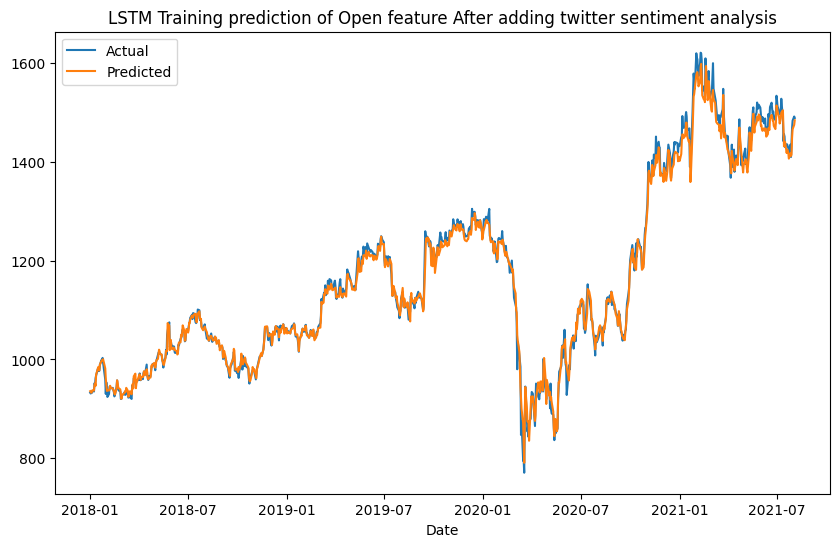

Mean square error for Open =212.2955546814128


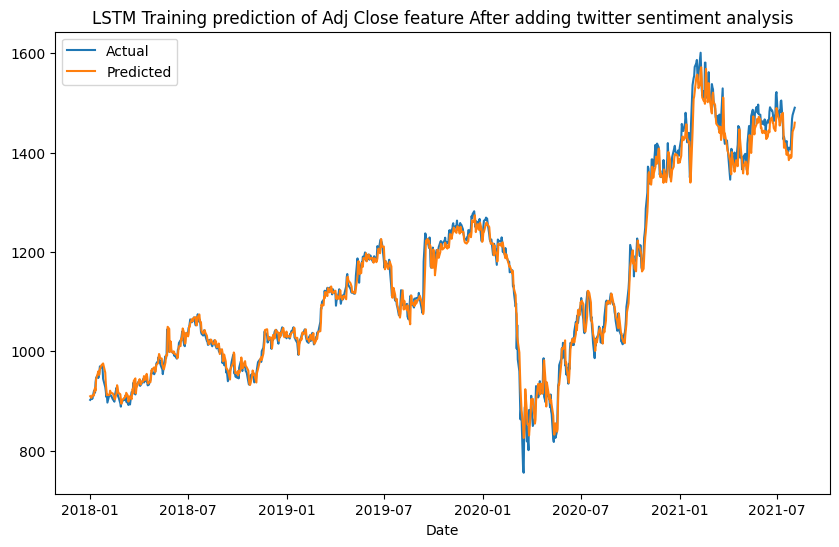

Mean square error for Adj Close =427.0367539887541
Total mean square error 319.66615433508355
RMSE : 17.87921011496547


In [ ]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_twitter)

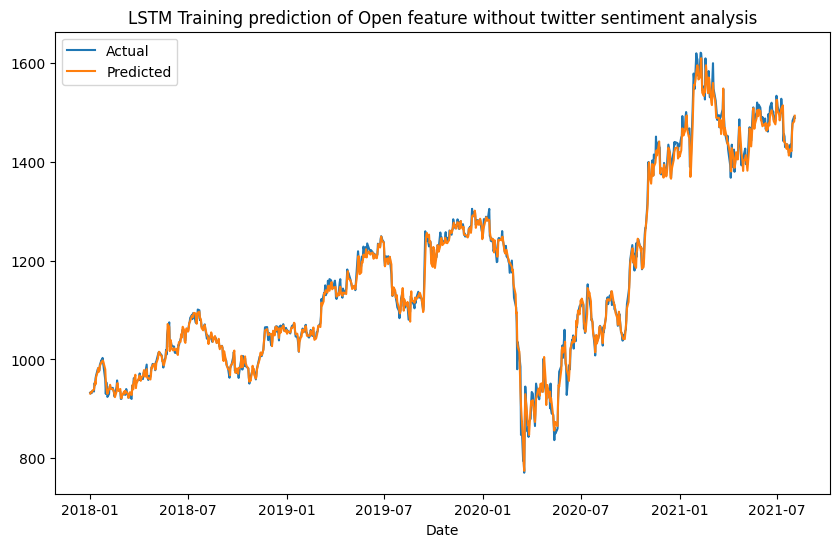

Mean square error for Open =146.52174943771405


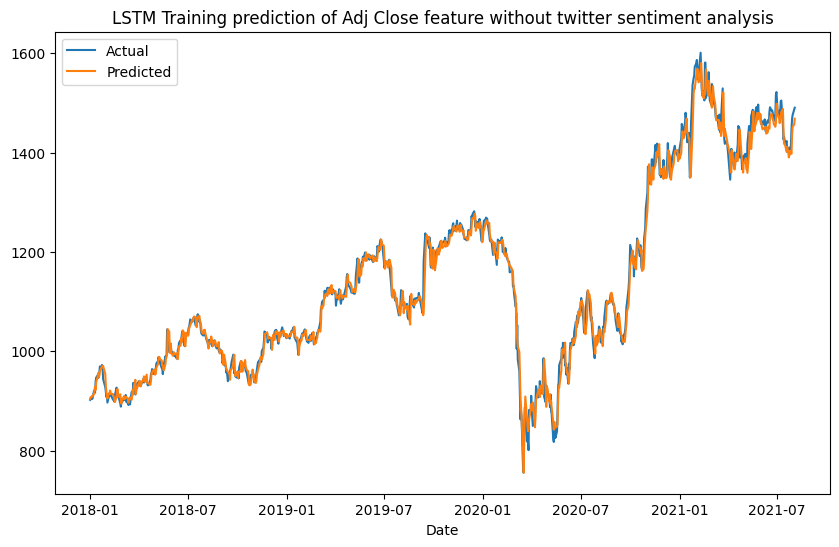

Mean square error for Adj Close =363.808321329606
Total mean square error 255.16503538366004
RMSE : 15.973886045156952


In [ ]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_twitter)

In [ ]:
testing_dates= df_for_training.index[-X_test_lstm_without_twitter.shape[0]:]
#Make prediction
testing_prediction_without_twitter = cnn_lstm_model_without_twitter.predict(X_test_lstm_without_twitter)
testing_prediction_twitter = cnn_lstm_model_twitter.predict(X_test_lstm_twitter)

testing_prediction_without_twitter=testing_prediction_without_twitter.reshape(testing_prediction_without_twitter.shape[0], testing_prediction_without_twitter.shape[2])
testing_prediction_twitter=testing_prediction_twitter.reshape(testing_prediction_twitter.shape[0], testing_prediction_twitter.shape[2])

y_test_pred_lstm_without_twitter = scaler_for_inference.inverse_transform(testing_prediction_without_twitter)
y_test_pred_lstm_twitter = scaler_for_inference.inverse_transform(testing_prediction_twitter)

y_test_actual_lstm_reshaped_without_twitter=y_test_lstm_without_twitter.reshape(y_test_lstm_without_twitter.shape[0], y_test_lstm_without_twitter.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_twitter)

8/8 [==============================] - 0s 10ms/step


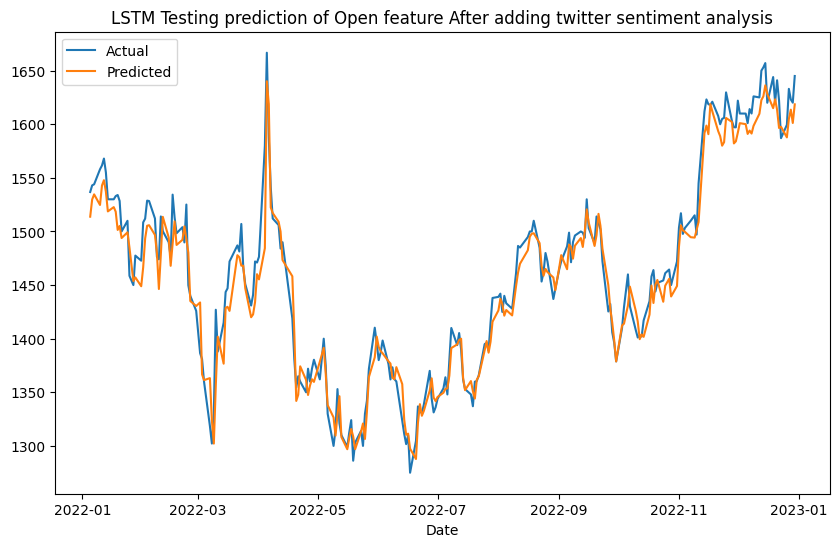

Mean square error for Open =366.20326479518314


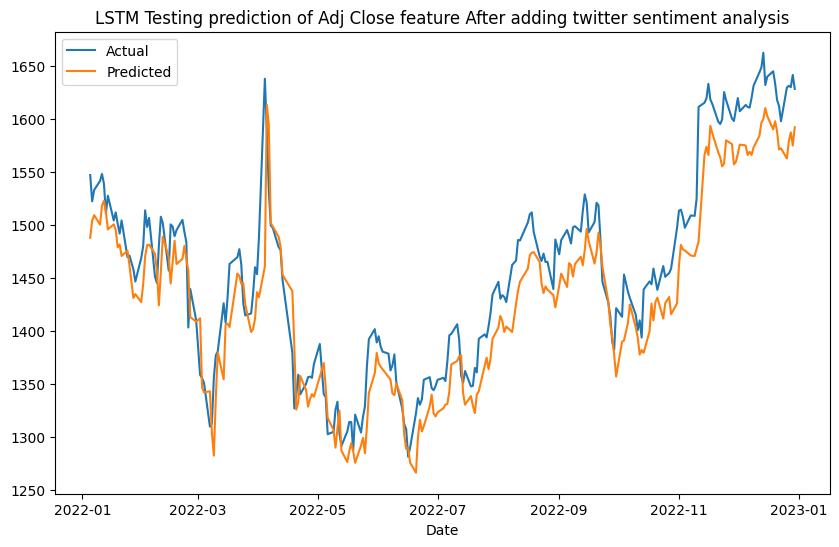

Mean square error for Adj Close =1396.6525823602954
Total mean square error 881.4279235777392
RMSE : 29.68885184000451


In [ ]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_twitter)

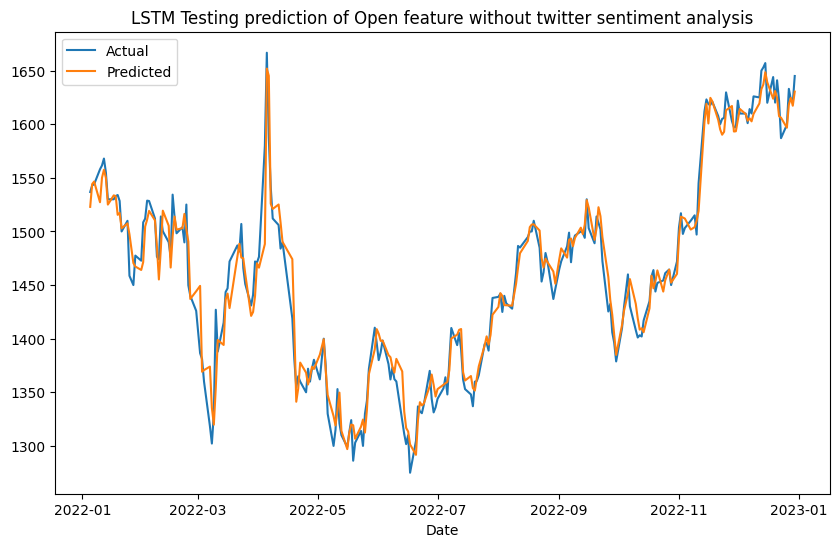

Mean square error for Open =328.2542371463364


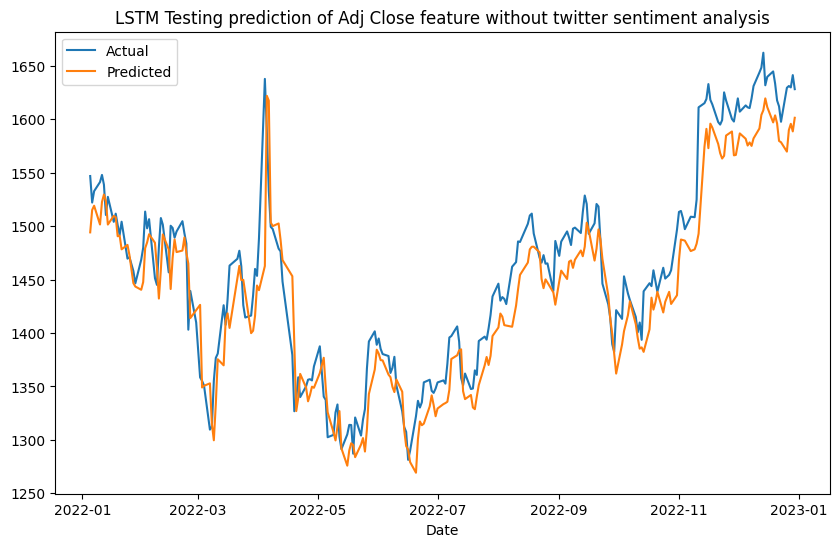

Mean square error for Adj Close =1121.813893634614
Total mean square error 725.0340653904752
RMSE : 26.926456606662438


In [ ]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_twitter)

##Data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.DataFrame(df_for_training, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean', 'twt_count'])
data['Date'] = df['Date']

In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.2)

In [ ]:
train_X_without_twitter = train[['Open', 'High', 'Low', 'Volume']]
train_y_without_twitter = train['Close']
test_X_without_twitter = test[['Open', 'High', 'Low', 'Volume']]
test_y_without_twitter = test['Close']

train_X_with_twitter = train[['Open', 'High', 'Low', 'Volume', 'P_mean']]
train_y_with_twitter = train['Close']
test_X_with_twitter = test[['Open', 'High', 'Low', 'Volume', 'P_mean']]
test_y_with_twitter = test['Close']

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [ ]:
RF_model1 = RandomForestClassifier()
RF_model2 = RandomForestClassifier()

In [ ]:
train_X_without_twitter = train_X_without_twitter.astype(int)
train_X_with_twitter = train_X_with_twitter.astype(int)
train_y_without_twitter = train_y_without_twitter.astype(int)
train_y_with_twitter = train_y_with_twitter.astype(int)

test_X_without_twitter = test_X_without_twitter.astype(int)
test_y_without_twitter = test_y_without_twitter.astype(int)
test_X_with_twitter = test_X_with_twitter.astype(int)
test_y_with_twitter = test_y_with_twitter.astype(int)

In [ ]:
RF_model1.fit(train_X_without_twitter, train_y_without_twitter)
RF_model2.fit(train_X_with_twitter, train_y_with_twitter)

RandomForestClassifier()

In [ ]:
prediction1 = RF_model1.predict(test_X_without_twitter)
prediction2 = RF_model2.predict(test_X_with_twitter)

RMSE value for Random Forest Model :  19.524717024806925


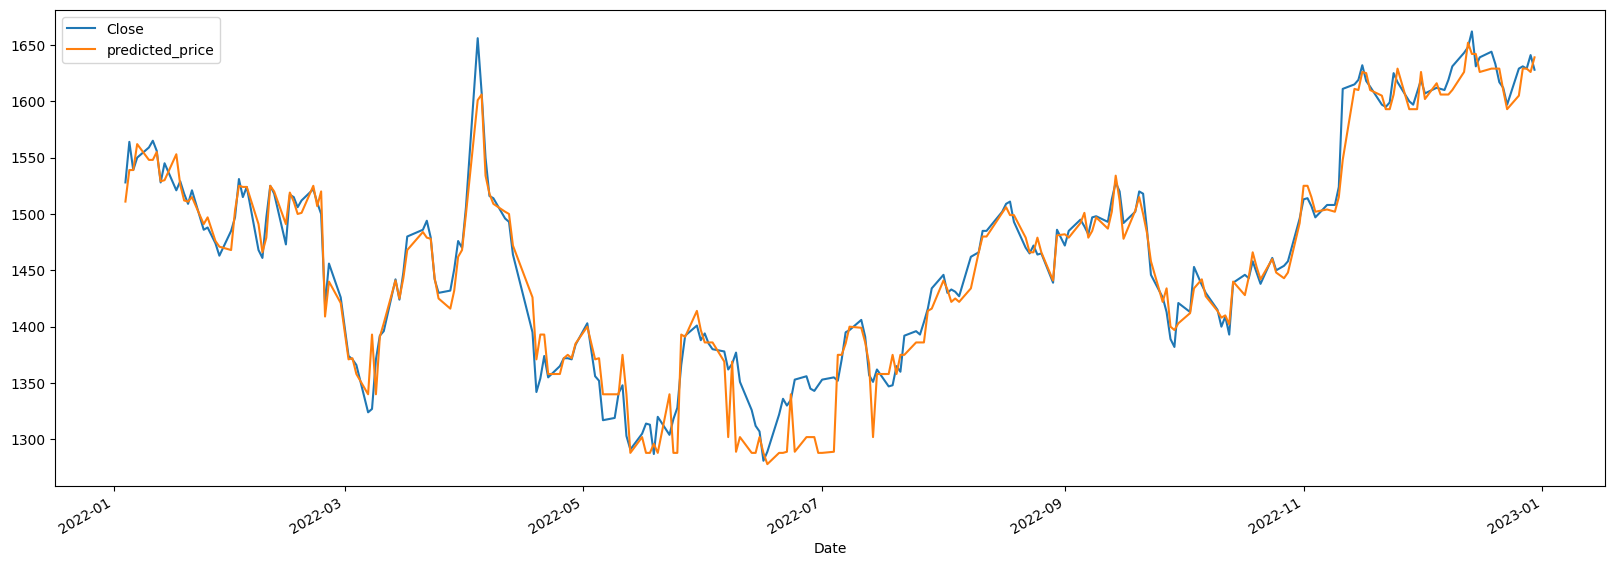

In [ ]:
predictions_df1 = pd.DataFrame(test_y_without_twitter)
predictions_df1['predicted_price'] = prediction1[0:]

predictions_df1.plot(figsize=(20,7))
rmse = sqrt(mean_squared_error(test_y_without_twitter, prediction1.flatten()))
print("RMSE value for Random Forest Model : ", rmse)

RMSE value for Random Forest Model :  17.781626326571306


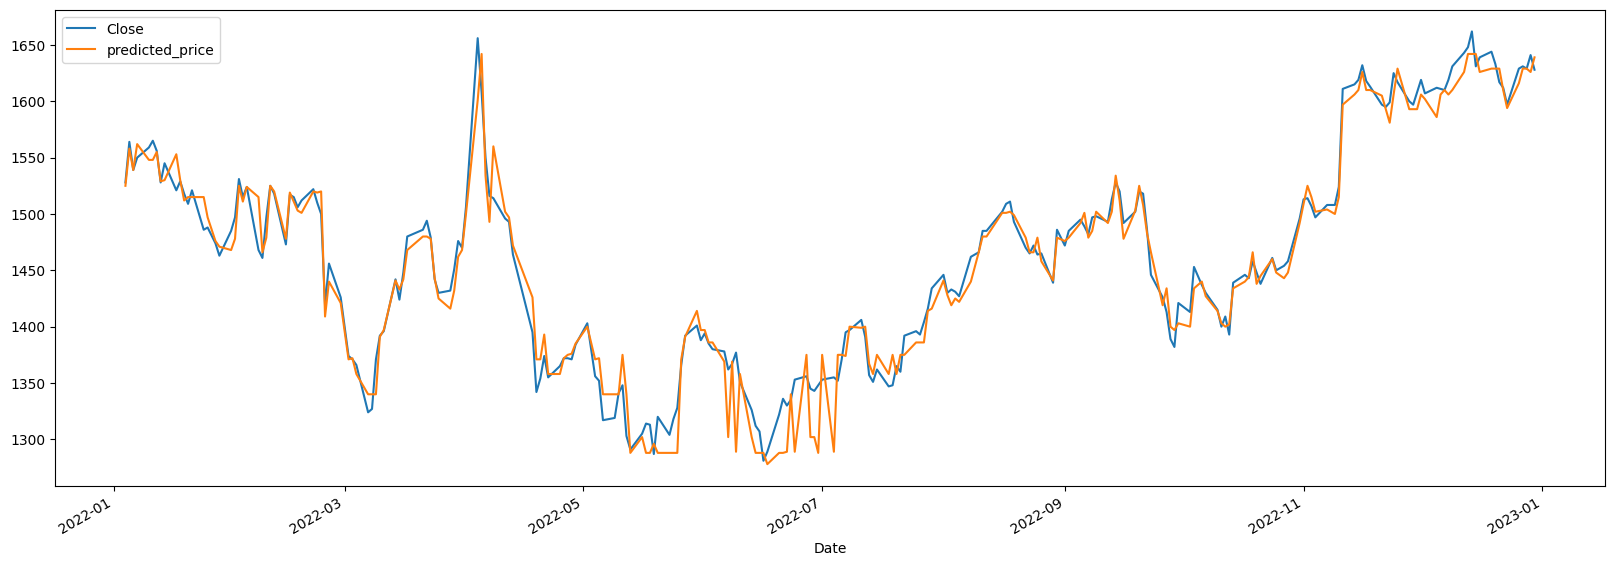

In [ ]:
predictions_df2 = pd.DataFrame(test_y_with_twitter)
predictions_df2['predicted_price'] = prediction2[0:]

predictions_df2.plot(figsize=(20,7))
rmse = sqrt(mean_squared_error(test_y_with_twitter, prediction2.flatten()))
print("RMSE value for Random Forest Model : ", rmse)

##XG Boost

In [ ]:
# Necessary imports
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [ ]:


xgb_r1 = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
xgb_r2 = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r1.fit(train_X_without_twitter, train_y_without_twitter.values.flatten())
xgb_r2.fit(train_X_with_twitter, train_y_with_twitter.values.flatten())
  
# Predict the model
pred1 = xgb_r1.predict(test_X_without_twitter)
pred2 = xgb_r2.predict(test_X_with_twitter)
  
# RMSE Computation
rmse1 = np.sqrt(MSE(test_y_without_twitter, pred1))
rmse2 = np.sqrt(MSE(test_y_with_twitter, pred2))
print("RMSE without twitter : % f" %(rmse1))
print("RMSE with twitter: % f" %(rmse2))

[09:02:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:39] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE without twitter :  44.663362
RMSE with twitter:  44.663362


##Support Vector Machine

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['Open','Adj Close']])

df_for_training_scaled

array([[0.17751855, 0.14248634, 0.20005363, ..., 0.05245646, 0.1572112 ,
        0.64957265],
       [0.16994812, 0.13934426, 0.20437117, ..., 0.03562152, 0.1666844 ,
        0.43981481],
       [0.17874912, 0.14112022, 0.20042904, ..., 0.03333517, 0.15622943,
        0.48717949],
       ...,
       [0.91236421, 0.89945355, 0.94861891, ..., 0.07215745, 0.95677835,
        0.59889677],
       [0.90915411, 0.91092896, 0.93563958, ..., 0.09381489, 0.96936474,
        0.50906225],
       [0.93579798, 0.91256831, 0.94529364, ..., 0.05751501, 0.95497244,
        0.53481481]])

In [ ]:
data1 = pd.DataFrame(df_for_training_scaled, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'P_mean'])

In [ ]:
data1

,Open,High,Low,Close,Volume,Adj Close,P_mean
0,0.177519,0.142486,0.200054,0.173236,0.052456,0.157211,0.649573
1,0.169948,0.139344,0.204371,0.182926,0.035622,0.166684,0.439815
2,0.178749,0.141120,0.200429,0.172231,0.033335,0.156229,0.487179
3,0.166979,0.134153,0.201394,0.176167,0.013203,0.160077,0.562963
4,0.172329,0.135546,0.202762,0.178176,0.017842,0.162041,0.490460
...,...,...,...,...,...,...,...
1230,0.887111,0.906011,0.913113,0.935668,0.083499,0.956395,0.524579
1231,0.922958,0.902678,0.938321,0.937459,0.065018,0.958201,0.570571
1232,0.912364,0.899454,0.948619,0.936048,0.072157,0.956778,0.598897
1233,0.909154,0.910929,0.935640,0.948534,0.093815,0.969365,0.509062


In [ ]:
train, test = train_test_split(data1, shuffle=False, test_size=0.2)

In [ ]:
train_X_without_twitter = train[['Open', 'High', 'Low', 'Volume']]
train_y_without_twitter = train['Close']
test_X_without_twitter = test[['Open', 'High', 'Low', 'Volume']]
test_y_without_twitter = test['Close']

train_X_with_twitter = train[['Open', 'High', 'Low', 'Volume', 'P_mean']]
train_y_with_twitter = train['Close']
test_X_with_twitter = test[['Open', 'High', 'Low', 'Volume', 'P_mean']]
test_y_with_twitter = test['Close']

In [ ]:
df_for_training['Close'].min()

767.7000122070312

In [ ]:
df_for_training['Close'].max()

1688.699951171875

In [ ]:
from sklearn import svm
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
svr_rbf1 = SVR(kernel='rbf', C=1, gamma=0.0001)
svr_rbf2 = SVR(kernel='rbf', C=1, gamma=0.0001)

svr_rbf1.fit(train_X_without_twitter.values, train_y_without_twitter.values)
svr_rbf2.fit(train_X_with_twitter.values, train_y_with_twitter.values)

output_test_svm1 = svr_rbf1.predict(test_X_without_twitter)
output_test_svm2 = svr_rbf2.predict(test_X_with_twitter)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(


In [ ]:
actual = pd.DataFrame(test_y_without_twitter)

In [ ]:
scaler = MinMaxScaler(feature_range=(379, 1898))
scaler = scaler.fit(actual)
actual1 = scaler.transform(actual)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(actual)

actual1

array([[1364.88475689],
       [1509.62710054],
       [1409.54344704],
       [1452.60756641],
       [1486.89911278],
       [1513.81406569],
       [1476.93061169],
       [1362.69149196],
       [1431.07550672],
       [1336.77338915],
       [1367.6757425 ],
       [1324.61162313],
       [1286.93088374],
       [1337.17203184],
       [1197.81258143],
       [1203.39503938],
       [1151.15970433],
       [1104.50731397],
       [1194.02425897],
       [1239.08207856],
       [1375.45097865],
       [1312.25077914],
       [1346.74189023],
       [1124.04567343],
       [1098.92485601],
       [1241.47442147],
       [1351.12793336],
       [1326.20668065],
       [1146.17545379],
       [1322.02020225],
       [1313.84583666],
       [1276.96238266],
       [1300.28857784],
       [1339.16573206],
       [1293.70926978],
       [1254.63303759],
       [ 929.65990236],
       [1075.99730353],
       [ 956.97349797],
       [ 749.62867549],
       [ 736.66962408],
       [ 718.726

In [ ]:
predicted = pd.DataFrame(output_test_svm1)

In [ ]:
scaler = MinMaxScaler(feature_range=(379, 1898))
scaler = scaler.fit(predicted)
predicted1 = scaler.transform(predicted)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(predicted)

predicted1

array([[1349.18432014],
       [1450.49356598],
       [1439.54954169],
       [1464.67154822],
       [1504.56224874],
       [1507.96076643],
       [1526.92630029],
       [1426.9278315 ],
       [1398.31120095],
       [1402.85638924],
       [1410.13540484],
       [1382.05410186],
       [1340.87668753],
       [1287.38322493],
       [1264.49415609],
       [1127.34797496],
       [1082.40284494],
       [1156.45432714],
       [1171.97716715],
       [1263.03746245],
       [1335.94140222],
       [1371.43223844],
       [1367.31279434],
       [1253.96835729],
       [1128.35399272],
       [1186.06919536],
       [1333.94363601],
       [1299.89813772],
       [1208.39911531],
       [1231.11404647],
       [1369.21496761],
       [1317.79499678],
       [1275.52994037],
       [1309.22100349],
       [1267.16380632],
       [1329.65582932],
       [1033.65910638],
       [1044.58479372],
       [ 959.49980143],
       [ 764.67055916],
       [ 770.15092847],
       [ 697.401

In [ ]:
actual = pd.DataFrame(test_y_with_twitter)

In [ ]:
df['Adj Close'].min()

755.6062622070312

In [ ]:
scaler = MinMaxScaler(feature_range=(379, 1898))
scaler = scaler.fit(actual)
actual2 = scaler.transform(actual)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(actual)

actual2

array([[1364.88475689],
       [1509.62710054],
       [1409.54344704],
       [1452.60756641],
       [1486.89911278],
       [1513.81406569],
       [1476.93061169],
       [1362.69149196],
       [1431.07550672],
       [1336.77338915],
       [1367.6757425 ],
       [1324.61162313],
       [1286.93088374],
       [1337.17203184],
       [1197.81258143],
       [1203.39503938],
       [1151.15970433],
       [1104.50731397],
       [1194.02425897],
       [1239.08207856],
       [1375.45097865],
       [1312.25077914],
       [1346.74189023],
       [1124.04567343],
       [1098.92485601],
       [1241.47442147],
       [1351.12793336],
       [1326.20668065],
       [1146.17545379],
       [1322.02020225],
       [1313.84583666],
       [1276.96238266],
       [1300.28857784],
       [1339.16573206],
       [1293.70926978],
       [1254.63303759],
       [ 929.65990236],
       [1075.99730353],
       [ 956.97349797],
       [ 749.62867549],
       [ 736.66962408],
       [ 718.726

In [ ]:
predicted = pd.DataFrame(output_test_svm2)

In [ ]:
scaler = MinMaxScaler(feature_range=(379, 1898))
scaler = scaler.fit(predicted)
predicted2 = scaler.transform(predicted)

scaler_for_inference = MinMaxScaler()
scaler_for_inference.fit_transform(predicted)

predicted2

array([[1342.15675038],
       [1442.2223971 ],
       [1453.94966854],
       [1478.7617938 ],
       [1496.86680719],
       [1506.87322675],
       [1515.20173577],
       [1421.01701369],
       [1384.75852598],
       [1402.60327535],
       [1404.09070974],
       [1377.8165166 ],
       [1332.58444238],
       [1267.22032158],
       [1269.71198832],
       [1135.05562261],
       [1084.05874384],
       [1135.54324214],
       [1168.22221878],
       [1266.00412682],
       [1339.01846933],
       [1371.90514   ],
       [1347.32787747],
       [1254.43733701],
       [1139.1376368 ],
       [1208.57755186],
       [1363.07778089],
       [1301.98508584],
       [1193.59927581],
       [1221.37220426],
       [1356.01713741],
       [1326.51178728],
       [1286.98635385],
       [1313.933417  ],
       [1258.81186121],
       [1322.86014154],
       [1011.97403856],
       [1034.43606352],
       [ 957.01815693],
       [ 754.94646577],
       [ 754.66361281],
       [ 704.872

In [ ]:
rmse1 = np.sqrt(MSE(actual1, predicted1))
rmse2 = np.sqrt(MSE(actual2, predicted2))
print("RMSE without twitter : % f" %(rmse1))
print("RMSE with twitter: % f" %(rmse2))

RMSE without twitter :  47.035054
RMSE with twitter:  45.892901
